<a href="https://colab.research.google.com/github/Demon-God-King/GoogleColab/blob/main/Project2_chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Michael Silva, Mehul Pakhare, Emilia Lepe


---


Title: CST 363 - Project 2 



# Introduction to Dataset

On September 16th 2022, there was controversy over an allegded cheating scandal at the world chess championship. This and current pop culture events, such as the release of the Netflix orginal series *The Queen's Gambit*, have caused an uptick in main stream media's attention in chess culture and game play. Popular streamers will play online chess, game variants, or even multi-dimensional chess with time travel and garner millions of views. 

We wanted to do an analysis on online chess player's skill, and attempt to predict a players Elo and subsequently who if more likely to win a match. lichess is an open source chess server that host millions of games daily and has game records dating back to 2013. We chose to look at the month of September for the year of 2013 during our analysis of player skill, as we do not have the computing power to look at the entirety of a year in chess matches. Additionally, this month falls within the scope of the World Chess Championship events. Analysis of player skill during this month would give insight to possible player training strategies.

In [ ]:
import numpy as np
import pandas as pd
import re 
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from itertools import count
from matplotlib import rcParams
import seaborn as sns        
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
import graphviz 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor

### Read Data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/asylum14/cst338/main/output2.csv')

###Preliminary exploration



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1717 entries, 0 to 1716
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   EVENT              1717 non-null   object
 1   SITE               1717 non-null   object
 2   WHITE_USERNAME     1717 non-null   object
 3   BLACK_USERNAME     1717 non-null   object
 4   RESULT             1717 non-null   object
 5   DATE               1717 non-null   object
 6   TIME               1717 non-null   object
 7   WHITE_ELO          1717 non-null   object
 8   BLACK_ELO          1717 non-null   int64 
 9   WHITE_RATING_DIFF  1717 non-null   object
 10  BLACK_RATING_DIFF  1717 non-null   object
 11  ECO                1717 non-null   object
 12  OPENING            1717 non-null   object
 13  TIME_CONTROL       1717 non-null   object
 14  TERMINATION        1716 non-null   object
 15  MOVES              1716 non-null   object
dtypes: int64(1), object(15)
memory usage: 214.

In [ ]:
df.head()

,EVENT,SITE,WHITE_USERNAME,BLACK_USERNAME,RESULT,DATE,TIME,WHITE_ELO,BLACK_ELO,WHITE_RATING_DIFF,BLACK_RATING_DIFF,ECO,OPENING,TIME_CONTROL,TERMINATION,MOVES
0,Rated Blitz game,https://lichess.org/vpztkmek,mohammad84,tjm,0-1,2013.08.31,22:11:30,1564,1692,-10,+7,C77,Ruy Lopez: Morphy Defense- Bayreuth Variation,300+0,Normal,1. e4 { [%eval 0.12] } 1... e5 { [%eval 0.15] ...
1,Rated Bullet game,https://lichess.org/1y4y5w9f,ThePersianGulf,unknown_13,1-0,2013.08.31,22:13:16,2016,1938,+9,-8,A43,Benoni Defense: Benoni Gambit Accepted,60+0,Time forfeit,1. d4 { [%eval 0.23] } 1... c5 { [%eval 0.39] ...
2,Rated Blitz game,https://lichess.org/udqfj5ip,dusann,bdgbdg,0-1,2013.08.31,22:15:47,1812,1769,-13,+12,C41,Philidor Defense: Bird Gambit,180+2,Normal,1. e4 { [%eval 0.16] } 1... e5 { [%eval 0.28] ...
3,Rated Bullet game,https://lichess.org/cn8eiu6d,unknown_13,djvoja23,0-1,2013.08.31,22:20:40,1939,2066,-8,+7,A40,Horwitz Defense,60+0,Time forfeit,1. d4 { [%eval 0.25] } 1... e6 { [%eval 0.31] ...
4,Rated Classical game,https://lichess.org/mcm2ngfo,CAVALO_VALENTE,suarez,1-0,2013.08.31,22:38:51,1341,917,+10,-3,B00,King's Pawn,1200+8,Normal,1. e4 { [%eval 0.26] } 1... b5?! { [%eval 1.25...


In [ ]:
df.describe()

,BLACK_ELO
count,1717.000000
mean,1659.559697
std,218.546306
min,807.000000
25%,1515.000000
50%,1661.000000
75%,1812.000000
max,2284.000000


General overview of the data reveals that different game types and their conclusions are recored. Within each of these matches we are given data about the players(black or white), their Elo ,which moves they made throughout the game and who won the match. Elo is a ranking system used within chess. This ranking accounts for players skill through wins and score and also their volatility in ranking. 

For matches conducted during the month of September 2013, the mean Elo for a player was about 1660. The highest Elo recorded during this month was 2284 and has held my the player "geochess". However, Elo as a measurement of skill can not guarantee a win. Therefore we must use other variables such as game moves to predict wins. 

### Data Preprocessing


lichess retains move data in a countinous string format. Every move played in the game and it's evlauation are recorded. In order for this data to be useful in our analysis all moves must we parced into induvidual moves rather than a continuous record. 

In [ ]:
df=df.dropna()
integers=['WHITE_ELO','BLACK_ELO']
strings = ['EVENT','SITE','WHITE_USERNAME','RESULT','BLACK_USERNAME','DATE','TIME','WHITE_RATING_DIFF','BLACK_RATING_DIFF',
            'ECO','OPENING','TIME_CONTROL','TERMINATION','MOVES']
df[integers]=df[integers].astype(int)
df[strings]=df[strings].astype('string');

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
dropData = ['WHITE_USERNAME', 'BLACK_USERNAME','SITE','DATE','TIME','WHITE_RATING_DIFF','BLACK_RATING_DIFF']
df=df.drop(dropData,axis=1)

In [ ]:
df['MOVES']

0       1. e4 { [%eval 0.12] } 1... e5 { [%eval 0.15] ...
1       1. d4 { [%eval 0.23] } 1... c5 { [%eval 0.39] ...
2       1. e4 { [%eval 0.16] } 1... e5 { [%eval 0.28] ...
3       1. d4 { [%eval 0.25] } 1... e6 { [%eval 0.31] ...
4       1. e4 { [%eval 0.26] } 1... b5?! { [%eval 1.25...
                              ...                        
1712    1. e4 { [%eval 0.17] } 1... d6 { [%eval 0.38] ...
1713    1. d4 { [%eval 0.28] } 1... e6 { [%eval 0.28] ...
1714    1. e4 { [%eval 0.18] } 1... e6 { [%eval 0.14] ...
1715    1. d4 { [%eval 0.17] } 1... d5 { [%eval 0.24] ...
1716    1. a3 { [%eval -0.12] } 1... e5 { [%eval 0.03]...
Name: MOVES, Length: 1716, dtype: string

Chess has many possible game plays. For the purposes of this analysis we will be reducing the resolution of the data. Our predictor variables will be based on peices moved and game events - such as captures, castlings and the frequency of peices moved witin the first 10 moves. 


In [ ]:
def plot_tree_custom(clf, predictors):
     
    target_names = ['White Loss','Draw','White Win']
    dot_data = export_graphviz(clf, precision=2,
                         feature_names=predictors,  
                         proportion=True,
                         class_names=target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)


    graph = graphviz.Source(dot_data)  
    return graph

In [ ]:

def moveSubstring(moveStr,moves,evalRemove=False):
  endPattern = f"{moves}..."
  stringCount = 0
  endIndex = moveStr.find(endPattern)+len(endPattern)
  i = endIndex
  if not evalRemove:
    while(moveStr[i]!= '{'):
        stringCount+=1
        i+=1
  else:
    while(moveStr[i]!= ' '):
        stringCount+=1
        i+=1
  return moveStr[:endIndex+stringCount-1]
def capturesInMoves(moveStr,moves=5):
  moveStr = moveSubstring(moveStr,moves)
  captureCount = 0
  for i in moveStr:
      if i == 'x':
        captureCount+=1
  return captureCount

def removeEval(moveStr):
    moveStr = re.sub('{ \[%eval -?[0-9]+.[0-9]+] }', '', moveStr, count=0, flags=0)
    moveStr = re.sub('{ \[%eval #-?[0-9]+] }', '', moveStr, count=0, flags=0)
    return moveStr

def removeBlunders(moveStr):
    moveStr = re.sub('\?+!*', '', moveStr, count=0, flags=0)
    moveStr = re.sub('!+\?*', '', moveStr, count=0, flags=0)
    return moveStr

def removeTurnNumbers(moveStr):
    moveStr = re.sub('[0-9]\.+ ', '', moveStr, count=0, flags=0)
    return moveStr

def numberOfPiecesMoved(moveStr,moves=10):  
  moveStr = formatMoveString(moveStr,moves_num=moves)
  moveArray=moveStr.split('  ')
  pawnMoves = 0
  rookMoves = 0
  knightMoves = 0
  bishopMoves = 0
  queenMoves = 0
  kingMoves = 0
  for i in moveArray:
    if i[0].islower():
      pawnMoves+=1 
    elif i[0] == 'R':
      rookMoves += 1
    elif i[0] == 'N':
      knightMoves += 1
    elif i[0] == 'B':
      bishopMoves += 1
    elif i[0] == 'Q':
      queenMoves += 1
    elif i[0] == 'K':
      kingMoves += 1

  return (pawnMoves,rookMoves,knightMoves,bishopMoves,queenMoves,kingMoves)

def formatMoveString(moveStr, moves_num=0, Eval=False,turnNum=False, blunders=False):
  if moves_num > 0:
    moveStr = moveSubstring(moveStr,moves_num)
  if not Eval:
    moveStr = removeEval(moveStr)
  if not turnNum:
    moveStr = removeTurnNumbers(moveStr)
  if not blunders:
   moveStr = removeBlunders(moveStr)
  

  return moveStr

def centerControl(moveString, moves=10):
  moveString = formatMoveString(moveString,moves_num=moves)

  centerMoves=moveString.count('d4')+moveString.count('e4')
  centerMoves+=moveString.count('d5')+moveString.count('e5')

  return centerMoves


def moveCastled(moveString):
  moveString = formatMoveString(moveString, turnNum=True)
  castleIndex = moveString.find('O-O')
  count = 0
  if castleIndex < 0 :
    return 0
  if moveString[castleIndex-3] !='.':
    turnNumSpace = moveString[castleIndex-6:castleIndex-2]    
  else:
     turnNumSpace = moveString[castleIndex-8:castleIndex-4]
  for i in range(len(turnNumSpace)-1,-1,-1):
    if turnNumSpace[i]!= ' ':
      count+=1
    else:
      break
  turnNumSpace = turnNumSpace[-count:]
  return int(turnNumSpace)

def moveCaptured(moveString):
  moveString = formatMoveString(moveString, turnNum=True)
  captureIndex = moveString.find('x')
  count = 0
  if captureIndex < 0 :
    return 0
  moveString = moveString[captureIndex-10:captureIndex]
  for i in range(len(moveString)-1,-1,-1):
    if(moveString[i].isnumeric()):
      moveString = moveString[i-2:i+1]
      break
  
  for i in range(len(moveString)):
    if(moveString[i].isnumeric()):
      moveString = moveString[i:]
      break
  return int(moveString)

def convertToClass(n,mean=0,std=1):
  return round((n-mean)/std)

def modifyResult(s):
  if s=='0-1':
    return -1
  elif s== '1-0':
    return 1
  else:
    return 0

def findnth(moveString,s,n):
  for i in range(len(moveString)):     
    if moveString[i]==s[0]:
      for j in range(len(s)):
        if moveString[i+j] !=s[j]:
          break
      else:
       n-=1 
    if n == 0:
      return i
  return -1

def getPieceTaken(moveString,position):
  intialPositionPiece ={'a1':'R','b1':'N','c1':'B','d1':'Q',
                        'e1':'K','f1':'B','g1':'N','h1':'R',                        
                        'a8':'R','b8':'N','c8':'B','d8':'Q',
                        'e8':'K','f8':'B','g8':'N','h8':'R'}
  #print(intialPositionPiece[position])
  reArray = re.findall(position, moveString)
  if len(reArray)==1:
    if position not in intialPositionPiece.keys():
      return 'p'
    return intialPositionPiece[position]
  tempindex=findnth(moveString,position,len(reArray)-1)
  if moveString[tempindex-1] =='x':
    tempindex-=1
  if moveString[tempindex-1] ==' ':
    tempindex+=1  
  return moveString[tempindex-1]
  

def getLastMove(moveString):
  reArray=re.findall(' [0-9]+\. ',moveString)
  return int(reArray[-1][1:-2])


def getMaterialInbalance(moveString, moves=15):
  moveString = formatMoveString(moveString, turnNum=True)
  if moves>getLastMove(moveString)-1:
    moves=getLastMove(moveString)-1
  moveString = moveSubstring(moveString,moves, evalRemove=True) 
  
  captureIndex = 0
  count=1
  inbalance=0
  while captureIndex!=-1:
    captureIndex = findnth(moveString,'x',count)
    if  captureIndex==-1:
      break
    tempMoveString = moveString[:captureIndex+3]
    position = tempMoveString[captureIndex+1:captureIndex+3]    
    if moveString[captureIndex-4]=='.':
      whiteTurn = False 
    else:
      whiteTurn = True
    count+=1
    pieceTaken = getPieceTaken(tempMoveString,position)

    if pieceTaken.islower():
      if whiteTurn:
        inbalance+=1
      else:
        inbalance-=1
    elif pieceTaken=='R':
      if whiteTurn:
        inbalance+=5
      else:
        inbalance-=5
    elif pieceTaken=='N' or pieceTaken=='B':
      if whiteTurn:
        inbalance+=3
      else:
        inbalance-=3
    else:
      if whiteTurn:
        inbalance+=9
      else:
        inbalance-=9
    
  return inbalance
  

def checkDifference(moveString):
    dif=0
    for i in range(len(moveString)):      
      if moveString[i] == '+':
        tempMoveString=moveString[i-12:i+1]
        reArray=re.findall(' [0-9]+\.\.\. ',tempMoveString)
        if len(reArray)==0:
          dif+=1
        else:
          dif-=1
    return dif

In [ ]:
def pawnMoves(t):
  return t[0]
def rookMoves(t):
  return t[1]
def knightMoves(t):
  return t[2]
def bishopMoves(t):
  return t[3]
def queenMoves(t):
  return t[4]
def kingMoves(t):
  return t[5]

In [ ]:
df['AVERAGE_ELO'] = (df['WHITE_ELO']+df['BLACK_ELO'])/2
df['CAPTURES_IN_5_MOVES']=df['MOVES'].apply(capturesInMoves)
df['CAPTURES_IN_10_MOVES']=df['MOVES'].apply(capturesInMoves,moves=10)
df['PIECE_MOVES_IN_10_TURNS'] = df['MOVES'].apply(numberOfPiecesMoved)
df['MOVE_CASTLED'] = df['MOVES'].apply(moveCastled)
df['MOVE_CAPTURED'] = df['MOVES'].apply(moveCaptured)
df['CENTER_MOVES_IN_10_TURNS'] = df['MOVES'].apply(centerControl)
df['RESULT'] = df['RESULT'].apply(modifyResult)
df['NUM_MOVES'] = df['MOVES'].apply(getLastMove)
df['MATERIAL_INBALANCE'] = df['MOVES'].apply(getMaterialInbalance,moves=20)
df['CHECK_DIFFERENCE'] = df['MOVES'].apply(checkDifference)

In [ ]:
df['PAWN_MOVES_IN_10_TURNS'] = df['PIECE_MOVES_IN_10_TURNS'].apply(pawnMoves)
df['ROOK_MOVES_IN_10_TURNS'] = df['PIECE_MOVES_IN_10_TURNS'].apply(rookMoves)
df['KNIGHT_MOVES_IN_10_TURNS'] = df['PIECE_MOVES_IN_10_TURNS'].apply(knightMoves)
df['BISHOP_MOVES_IN_10_TURNS'] = df['PIECE_MOVES_IN_10_TURNS'].apply(bishopMoves)
df['QUEEN_MOVES_IN_10_TURNS'] = df['PIECE_MOVES_IN_10_TURNS'].apply(queenMoves)
df['KING_MOVES_IN_10_TURNS'] = df['PIECE_MOVES_IN_10_TURNS'].apply(kingMoves)

### Data Visualization and Exploration

Currently, we know the average Elo of a player for the month of September in 2013 (about 1660). However, we need to understand the remaining context & distribution of possible Elo scores.

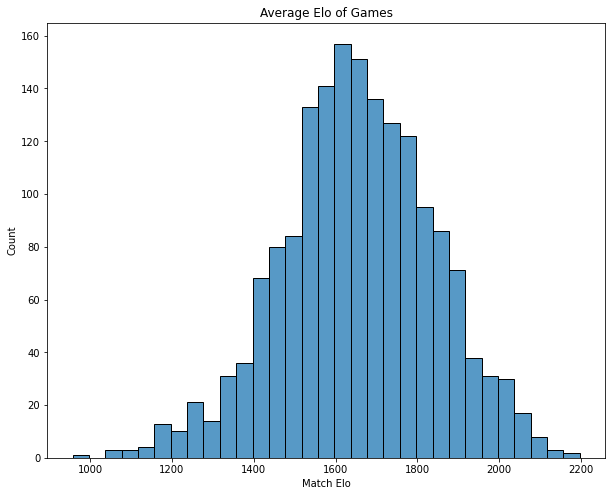

In [ ]:
plt.figure(figsize=(10,8))   
sns.histplot(df['AVERAGE_ELO'])
plt.title('Average Elo of Games')
plt.xlabel('Match Elo');

The players Elo rankings visually follow a normal guassian distribution. This means a average player with an Elo of 1660 is likely to be matched with someone similar in skill. We will now compare how player match up to eachother during thier matches. 

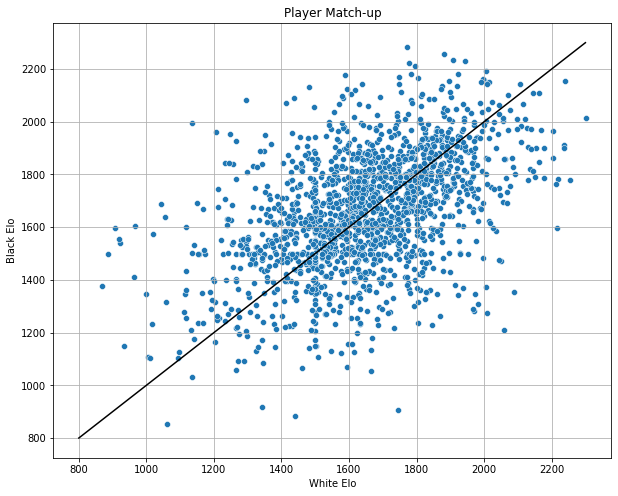

In [ ]:
plt.figure(figsize=(10,8))  
X_plot = np.linspace(800, 2300, 2300)
Y_plot = X_plot
plt.plot(X_plot, Y_plot, color='black')
plt.grid() 
sns.scatterplot(x='WHITE_ELO', y='BLACK_ELO', data=df)
plt.title('Player Match-up')
plt.ylabel('Black Elo')
plt.xlabel ('White Elo');

Match making visually follows a positive linear relationship. The black 1-1 line simulating a perfect player match-up based on Elo rankings. While the data has a general positive linear relationship, there are still cases of possible"unfair" match-making. These "unfair" matches could result in higher volitity and thus could significally alter a disadvantged player's Elo.

Players, for the most part, have a robust skill range and are fairly placed into matches. We now want to look into moves made within matches, up to the first ten moves, and when they take place. 

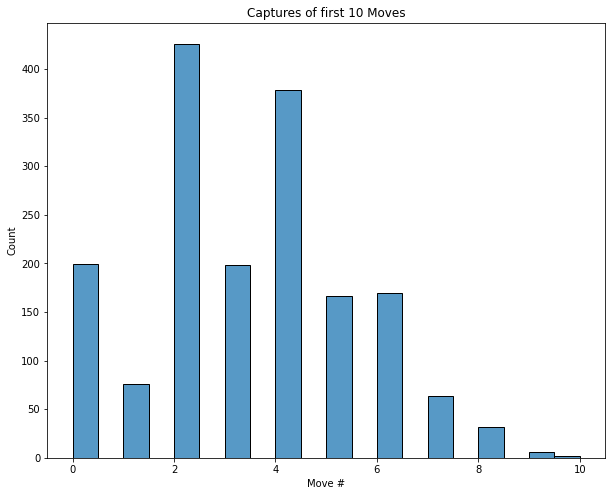

In [ ]:
plt.figure(figsize=(10,8))   
plt.title('Captures of first 10 Moves')
plt.xlabel('Move #')
sns.histplot(df['CAPTURES_IN_10_MOVES']);

In [ ]:
print('{:.2f}'.format(df['CAPTURES_IN_10_MOVES'].mean()))

3.30


On average there are about 4 captures within the first ten moves. 

In [ ]:
df['MOVE_CASTLED'] = pd.to_numeric(df['MOVE_CASTLED'])

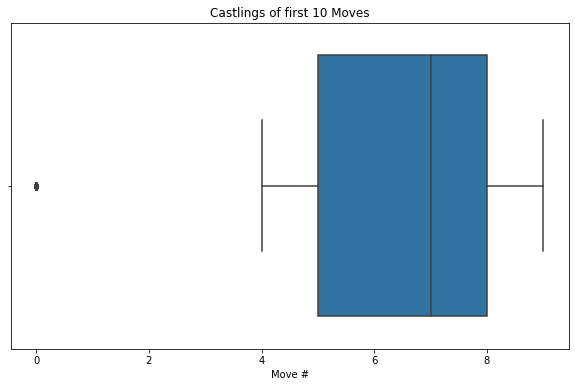

In [ ]:
plt.figure(figsize=(10,6))   
sns.boxplot(x=df['MOVE_CASTLED'][df['MOVE_CASTLED'] < 10])
plt.title('Castlings of first 10 Moves')
plt.xlabel('Move #');

In [ ]:
print('{:.2f}'.format(df['MOVE_CASTLED'][df['MOVE_CASTLED'] < 10].mean()))

6.01


The majority of castlings occur after move 6.

In addition to the average nature of player skill, match making and game events (captures and castlings), we can further define a players skill by the type of moves they conduct within the first 10 moves of the match. Chess peices , with the execption of the king, are assigned point values. Pawns are worth a single point, followed by bishops and knights worth three. Rooks are worth 5 points and Queens are worth nine points.

In [ ]:
# array of # of moves
data = np.array([df['PAWN_MOVES_IN_10_TURNS'].sum(), df['ROOK_MOVES_IN_10_TURNS'].sum(),df['BISHOP_MOVES_IN_10_TURNS'].sum(), df['KNIGHT_MOVES_IN_10_TURNS'].sum(), df['QUEEN_MOVES_IN_10_TURNS'].sum(), df['KING_MOVES_IN_10_TURNS'].sum()])
 
# index of peices
ser = pd.Series(data, index=['Pawn','Bishop','Knight','Rook','Queen','King'])
print(ser)

Pawn      13771
Bishop      237
Knight     5839
Rook       7275
Queen      2020
King        193
dtype: int64


Out of the first ten moves of all games conducted in September of 2013, the pawn peice was moved most often. This is to be expected as 1) they are inexpensive if captured and 2) starting pawn placement inhibits movement of more powerful peices. Therefore, pawns need to be moved out of the way.

The opening order of which a player moves their peices is called refered to as an "opening". There are many possible openings with various lengths of moves until completion. We want to know the five most common openings used by players. Understanding which opening your opponet is most likely to use will allow you the advantage of exploiting their plan and countering earlier.

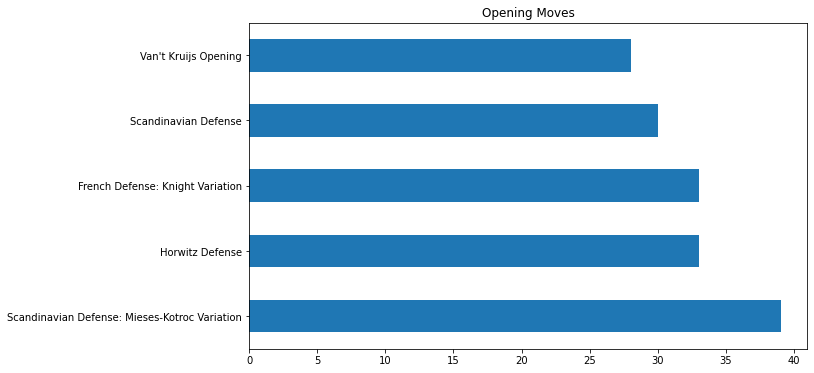

In [ ]:
plt.figure(figsize=(10,6))   
df['OPENING'].value_counts().head(5).plot.barh()
plt.title("Opening Moves");

We see that two variations of a Scandinavian defense are among the five most common openings with the Mieses-Kotroc variation being the most popular. The 2012 book *Chess in the Middle Ages and Early Modern Age: A Fundamental Thought Paradigm of the Premodern World* cited this opening as the oldest opening recored in modern history. Fundamentally, allowing highly skilled players to anticipate furture moves and disrupt thier opponet from creating a defensive pawn structure. 

Lastly, we need to understand the distrubtuion of win,losses, and draws dependant on player skill. Does a "better than average" player more often win? 

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1716 entries, 0 to 1716
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EVENT                     1716 non-null   string 
 1   RESULT                    1716 non-null   int64  
 2   WHITE_ELO                 1716 non-null   int64  
 3   BLACK_ELO                 1716 non-null   int64  
 4   ECO                       1716 non-null   string 
 5   OPENING                   1716 non-null   string 
 6   TIME_CONTROL              1716 non-null   string 
 7   TERMINATION               1716 non-null   string 
 8   MOVES                     1716 non-null   string 
 9   AVERAGE_ELO               1716 non-null   float64
 10  CAPTURES_IN_5_MOVES       1716 non-null   int64  
 11  CAPTURES_IN_10_MOVES      1716 non-null   int64  
 12  PIECE_MOVES_IN_10_TURNS   1716 non-null   object 
 13  MOVE_CASTLED              1716 non-null   int64  
 14  MOVE_CAP

In [ ]:
blackAdv = df[df['BLACK_ELO'] > df['WHITE_ELO']] 
bAdvWin = len(blackAdv[blackAdv['RESULT'] == -1])
bAdvlos = len(blackAdv[blackAdv['RESULT'] == 1])
bAdvdra = len(blackAdv[blackAdv['RESULT'] == 0])
bAdvlos

326

##### There were 326 games were black had the ranked advantage

In [ ]:
whiteAdv = df[df['WHITE_ELO'] > df['BLACK_ELO']] 
wAdvWin = len(whiteAdv[whiteAdv['RESULT'] == -1])
wAdvlos = len(whiteAdv[whiteAdv['RESULT'] == 1]) 
wAdvdra = len(whiteAdv[whiteAdv['RESULT'] == 0])
wAdvlos

512

There were 512 games where white had the ranked advantage

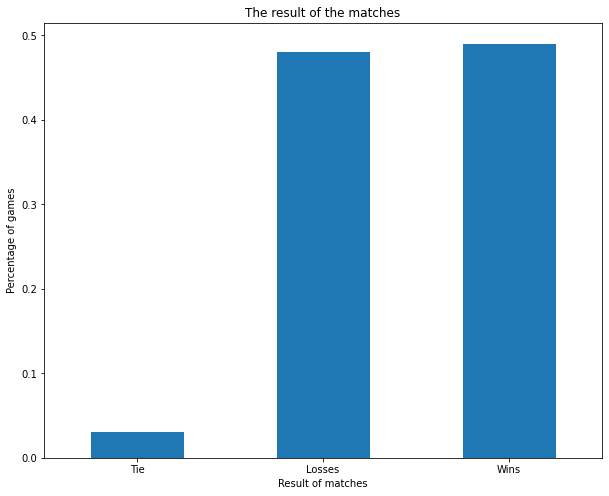

In [ ]:
labels=["Tie","Losses","Wins"]
fig, ax = plt.subplots()
x=df["RESULT"].value_counts(normalize=True).sort_values()
x.plot.bar(figsize=(10,8),rot=0)
ax.set_xticklabels(labels)
ax.set_ylabel('Percentage of games')
ax.set_xlabel('Result of matches')
ax.set_title('The result of the matches');

In [ ]:
AdvWin = (bAdvWin + wAdvWin) / ((bAdvWin + bAdvlos + bAdvdra) + (wAdvWin + wAdvlos + wAdvdra))

print("Proportion of times the advantaged player won the game: ") 
print((round(AdvWin,2)))

Proportion of times the advantaged player won the game: 
0.48


Interesting only half the time does the advantaged player win their game. This is most likely a result of fair match making. Even though they are ranked higher than their opponet, the skill range between the players is small or insignificant. Elo gives insight to a players skill contextly but not within their individual match.

# **Machine Learning**

#### Supervised Learning 

Initially our team were striving to predict the players Average Elo. However, after much trial and error we were only able to produce marginal improvements from just guessing the average. So we decided to change our target to predict who will win the game given the predictor variables.

In [ ]:
predictors = np.array(['MATERIAL_INBALANCE','CHECK_DIFFERENCE'])
target = 'RESULT'
X = df[predictors].values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.30, random_state=42)

We started our model testing with a Decision Tree Classifier.

In [ ]:
tree = DecisionTreeClassifier(random_state=42)
grid ={'max_depth':range(1,10)}
clf =  GridSearchCV(tree,grid,cv=10)
clf.fit(X_train,y_train);

After doing some hyperparameter tuning, and fitting the data to the model, we decided to determine what the baseline accuracy of our data would be.

In [ ]:
baseline = (df['RESULT'].value_counts().index[0] == df['RESULT']).mean()
print(f'Baseline Accuracy {100*baseline: .2f}%')

Baseline Accuracy  49.01%


as seen above the baseline accuracy is around 49%, which considering the possible outcomes of white wins, black wins and draw, it makes sense that it is close to 50%.

Next our team decided to see what the accuracy of our model was.

In [ ]:
y_pred = clf.predict(X_test)
accuracy=clf.score(X_test,y_test)
print(f"test accuracy: {100*accuracy: .2f}%")
print(f"Increased accuracy from baseline to Test accuracy: {100*(accuracy-baseline) : .2f}%")

test accuracy:  66.41%
Increased accuracy from baseline to Test accuracy:  17.40%


Our model predicted correctly around 66% of the time. That's an increase of around 17% accuracy.

Next we were curious what features were important to our model?

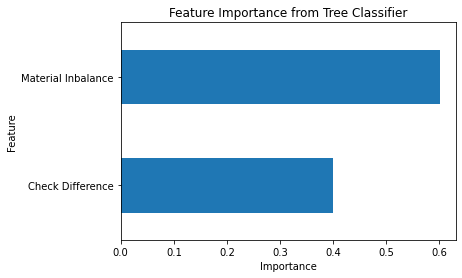

In [ ]:
featureImportance =clf.best_estimator_.feature_importances_
labels=['Check Difference','Material Inbalance']
ax = pd.Series(data=featureImportance, index=predictors).sort_values()[-10:].plot.barh();
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance from Tree Classifier')
ax.set_yticklabels(labels);

As it turns out the difference in checks between black and white was a more important factor than the difference of Material. Now we believe this to be because the Material inbalance only accounts for the first 20 moves while the check difference accounts for the entire game. We could account for the material inbalance at the end of the game, However the question would then become uninteresting because by that point most people could tell with a pretty high accuracy who won the game.

We then decided to plot the tree to determin what processes the model goes through to reach it's conclusion.

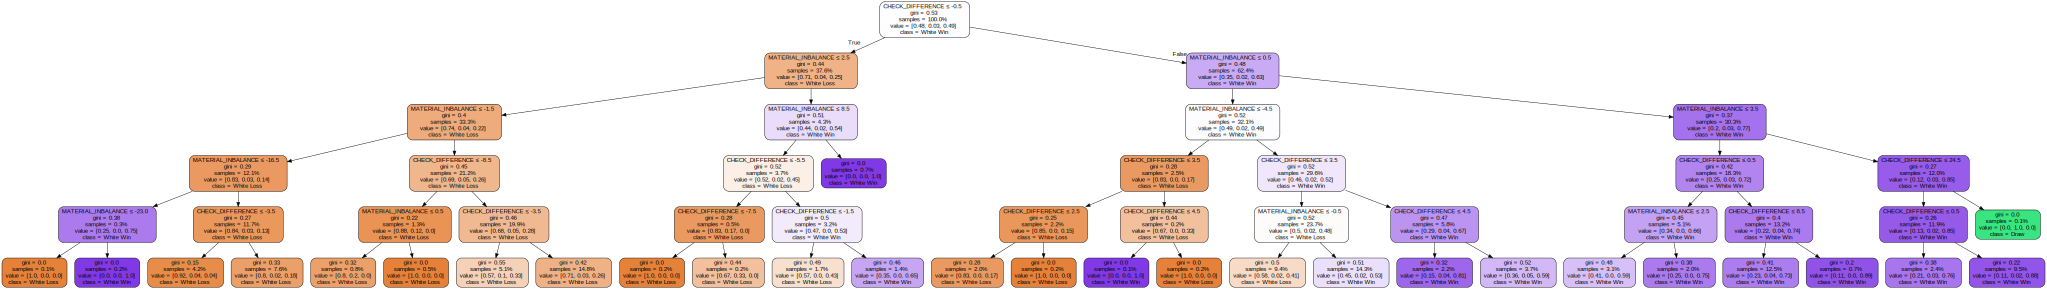

In [ ]:
plot_tree_custom(clf.best_estimator_,predictors)

One interesting thing to note is that if the check difference is greater than -0.5 and the material inbalance is greater than 0.5 the model will either predict that white will win or in a niche case that it is a draw. So if the game is close to even  but slightly in whites favor the model will almost alway predict that white will win.

## KNN Classifier

Even though we got pretty good returns from the Decision Tree Classifier. We decided to try out Knn also to see if we could get any better results.

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
knn = KNeighborsClassifier()
grid = {"n_neighbors": range(1,100)}
clf =  GridSearchCV(knn,grid,cv=10)
clf.fit(X_train,y_train);

In [ ]:
y_pred = clf.predict(X_test)
accuracy = clf.score(X_test, y_test)
print(f"test accuracy: {100*accuracy: .2f}%")
print(f"Increased accuracy from baseline to Test accuracy: {100*(accuracy-baseline) : .2f}%")

test accuracy:  67.57%
Increased accuracy from baseline to Test accuracy:  18.56%


After fitting the data to the model and determining the accuracy of the model we find that knn indeed does produce better results than the Decison Tree Classfier by about 1-2%. 




Here we have the data plotted out by the two features used.

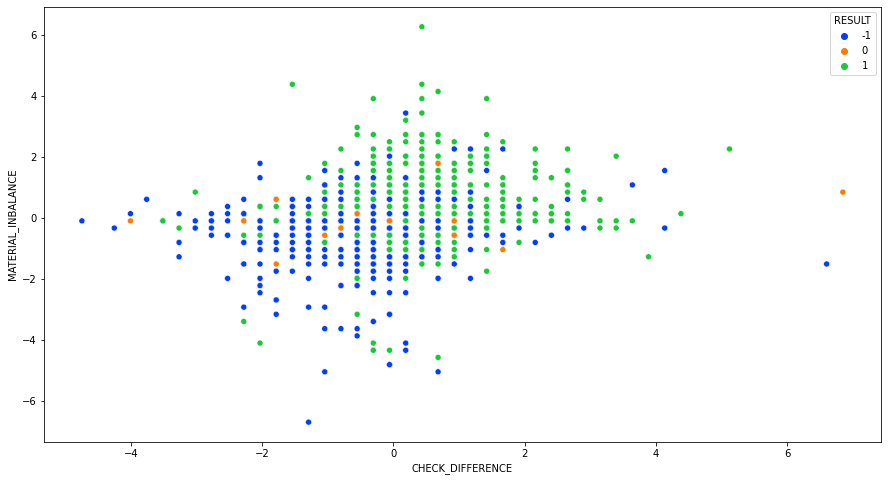

In [ ]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=df, x="CHECK_DIFFERENCE", y="MATERIAL_INBALANCE", hue="RESULT", palette="bright");

As we can see there seems to be correlation of the two features and the target resultwith some gray area. One interesting thing to note is that draws seem to be randomly dispersed throughout the data. However upon closer inspection draws seem to only occur within a certain range of material inbalance, within the -10 - 10 range and check difference doesn't seem to matter.




## Unsupervised Learning 

###Cluster Analysis

In [ ]:
features_cluster=df[['MATERIAL_INBALANCE','CHECK_DIFFERENCE']]
kmeans = KMeans(random_state=42)
grid_cluster = {"n_clusters": range(1,100)}
cla = GridSearchCV(kmeans,grid_cluster,cv=10)
cluster_fitted=cla.fit(features_cluster)
cluster_nums=cla.predict(features_cluster)

In [ ]:

np.sort(cluster_nums[:10])

array([ 2, 13, 30, 42, 46, 57, 63, 67, 67, 92], dtype=int32)

Cluster number for each row of X

In [ ]:
np.sort(np.bincount(cluster_nums))

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   2,   2,   2,   2,
         2,   2,   3,   3,   3,   3,   4,   4,   4,   4,   5,   5,   5,
         5,   5,   5,   5,   6,   6,   6,   6,   7,   7,   7,   7,   8,
         8,   8,   9,  10,  10,  10,  11,  11,  12,  12,  14,  14,  14,
        15,  15,  15,  16,  16,  16,  17,  19,  19,  19,  19,  20,  20,
        20,  20,  21,  22,  22,  22,  22,  22,  23,  23,  24,  26,  28,
        28,  29,  29,  29,  30,  30,  32,  32,  33,  34,  36,  37,  38,
        41,  42,  45,  46,  46,  60,  77, 134])

From the data we can see that maximum number of points in a cluster is 134 and the minimum is 1 

In [ ]:
centers=pd.DataFrame(cla.best_estimator_.cluster_centers_[:5], columns=['Material Inbalance','Check Difference'])
centers

,Material Inbalance,Check Difference
0,-5.625000e-01,-5.625000e+00
1,-4.444444e-01,3.250000e+00
2,-4.996004e-16,-2.498002e-16
3,3.000000e+00,2.775558e-17
4,-5.714286e+00,-1.071429e+00


These are the top 5 cluster center values

<Figure size 720x576 with 0 Axes>

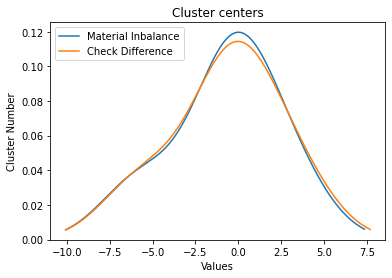

In [ ]:
plt.figure(figsize=(10,8))   
centers.plot.density()
plt.title('Cluster centers')
plt.xlabel('Values')
plt.ylabel('Cluster Number');

In [ ]:
score1 = silhouette_score(X, cla.best_estimator_.labels_, metric='euclidean')
print('Silhouetter Score: %.3f' % score1)

Silhouetter Score: 0.582


### Anomaly Detection 

In [ ]:
features_anomoly_detection=['MATERIAL_INBALANCE','CHECK_DIFFERENCE']
df[features_anomoly_detection] = StandardScaler().fit_transform(df[features_anomoly_detection])
features_ad_values = df[features_anomoly_detection].values

In [ ]:
ald = LocalOutlierFactor(n_neighbors=12)
outliers = ald.fit_predict(X)

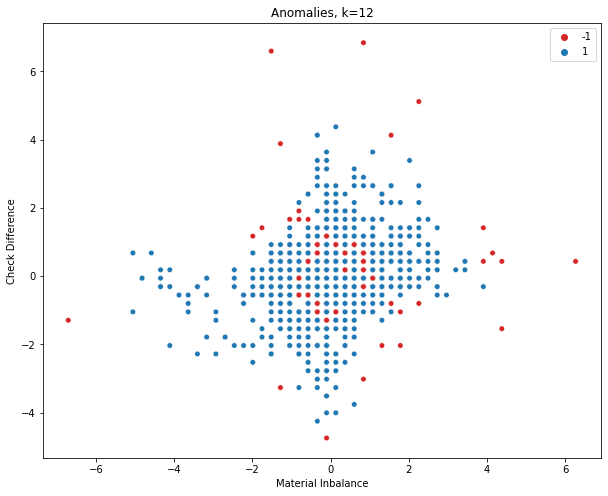

In [ ]:
plt.figure(figsize=(10,8))   
sns.scatterplot(x=features_anomoly_detection[0], y=features_anomoly_detection[1], data=df, s=30,hue=outliers, palette=['tab:red', 'tab:blue'])
plt.title('Anomalies, k={}'.format(ald.n_neighbors))
plt.xlabel("Material Inbalance")
plt.ylabel("Check Difference");

### Conclusions

The resolution of data needed to confidently predict which player will win their game can not be obtained from the first 10 moves of the game. Player background , Elo ranking, is near insignificant in determining which player will win on a induvidual game level. Effectivly, the lichess match making algorithm is effective in pairing players that will challenge eachothers skill as there is no obivous winner in early game. 

For players attempting to find insight for training techniques, we reccomend simply playing more games.